## Task2

in this task we have been given the task of using the 3 class data from the git [norec_sentences](https://github.com/ltgoslo/norec_sentence.git) and using the training data make a model that can as precisely predict of some Norwegian sentence.
The methods we will use are: 
- bag-of-words, for representing our text as numerical data;
- lemmatization and stop-word removal, to simplify our data;
- support vector machines, for predicting the correct label for some data;
- grid-search, to look for hyper-parameters;
- cross-validation, to score our models;
- and data balancing, to try to make our model less bias;

dependencies

In [14]:
# !python -m spacy download nb_core_news_sm
# !python -m spacy download nb_core_news_md
# !python -m spacy download nb_core_news_lg
# !pip install sklearn
# !pip install spacy
# !pip install json
# !pip install seaborn
# !pip install gitpython

download files used later

In [15]:
from git import Repo
from os import curdir

# repo = Repo.clone_from('https://github.com/ltgoslo/norec_sentence.git', curdir+'/norec_sentence')

In [16]:
import spacy
import pandas
from time import time
from IPython.display import clear_output
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

Our data consists of 3 lists (train, dev, test) containing dictionaries. Each dictionary contains the text, label and ID of a single review. Below we load this data with Python.

In [17]:
import json
data_3class = {}
for name in ["train", "dev", "test"]:
    with open(f"norec_sentence/3class/{name}.json") as infile:
        data_3class[name] = json.load(infile)

Since our training feature is the text of reviews and our target feature is the actual review rating, we split these two into separate sets of dictionaries, each containing their own train, dev and test sets. This makes it easier to handle our target and training data.

In [18]:
text = {'train': [x['text'] for x in data_3class['train']], 
        'dev' : [x['text'] for x in data_3class['dev']],
        'test':[x['text'] for x in data_3class['test']]}

labels ={'train':[x['label'] for x in data_3class['train']],
         'dev' : [x['label'] for x in data_3class['dev']],
         'test':[x['label'] for x in data_3class['test']]}

We have built a custom lemmatizer that can also remove stop words. Later, we will see what effect the removal of stop words has on model performance.

In [19]:
def lemmatizer(list_sentc:list, nlp:spacy, include_stop:bool)->list:
    """takes a list of sentences and returns a list of lemmatized sentences using the lemma_ 
    atribute from spacy, and list comprehention to filter out stopwords

    Args:
        list_sentc (list): a list of multiword sentences
        nlp (spacy): a spacy language model for lemmatization
        include_stop (bool): if true includes stopwords, if false removes stopwords
        
    Returns:
        list: lemmatized sentences
    """
    result = []
    for sentence in list_sentc:
        if nlp != None:
            doc = nlp(sentence.lower())
            if include_stop == False:
                result.append(' '.join([token.lemma_ for token in doc if token.is_stop is False]))
            else:
                result.append(' '.join([token.lemma_ for token in doc]))
        else:
            nlp = spacy.load('nb_core_news_sm')
            doc = nlp(sentence.lower())
            if include_stop == False:
                result.append(' '.join([token.text for token in doc if token.is_stop is False]))
            else:
                result.append(sentence)

    return result

We create a dictionary of several models so that we can easily test the performance of differing model sizes.

In [20]:
nb_nlp = {'none': None, 'small': spacy.load('nb_core_news_sm'), 'medium': spacy.load('nb_core_news_md'), 'large':spacy.load('nb_core_news_lg')}

In [21]:
# fits text to a vector and then makes document count matricees for each 
# combination for lemmatization model and if stopwords should be removed

text_comb = text['train'] + text['test'] + text['dev']

vectorizer = CountVectorizer()
vectorizer.fit(text_comb)

grid = {}
for stop in [True, False]:
    for nlp in nb_nlp:
        sentences = lemmatizer(text_comb, nb_nlp[nlp], stop)

        grid[f'{stop}-{nlp}'] = vectorizer.transform(sentences).toarray()


**make barplott**

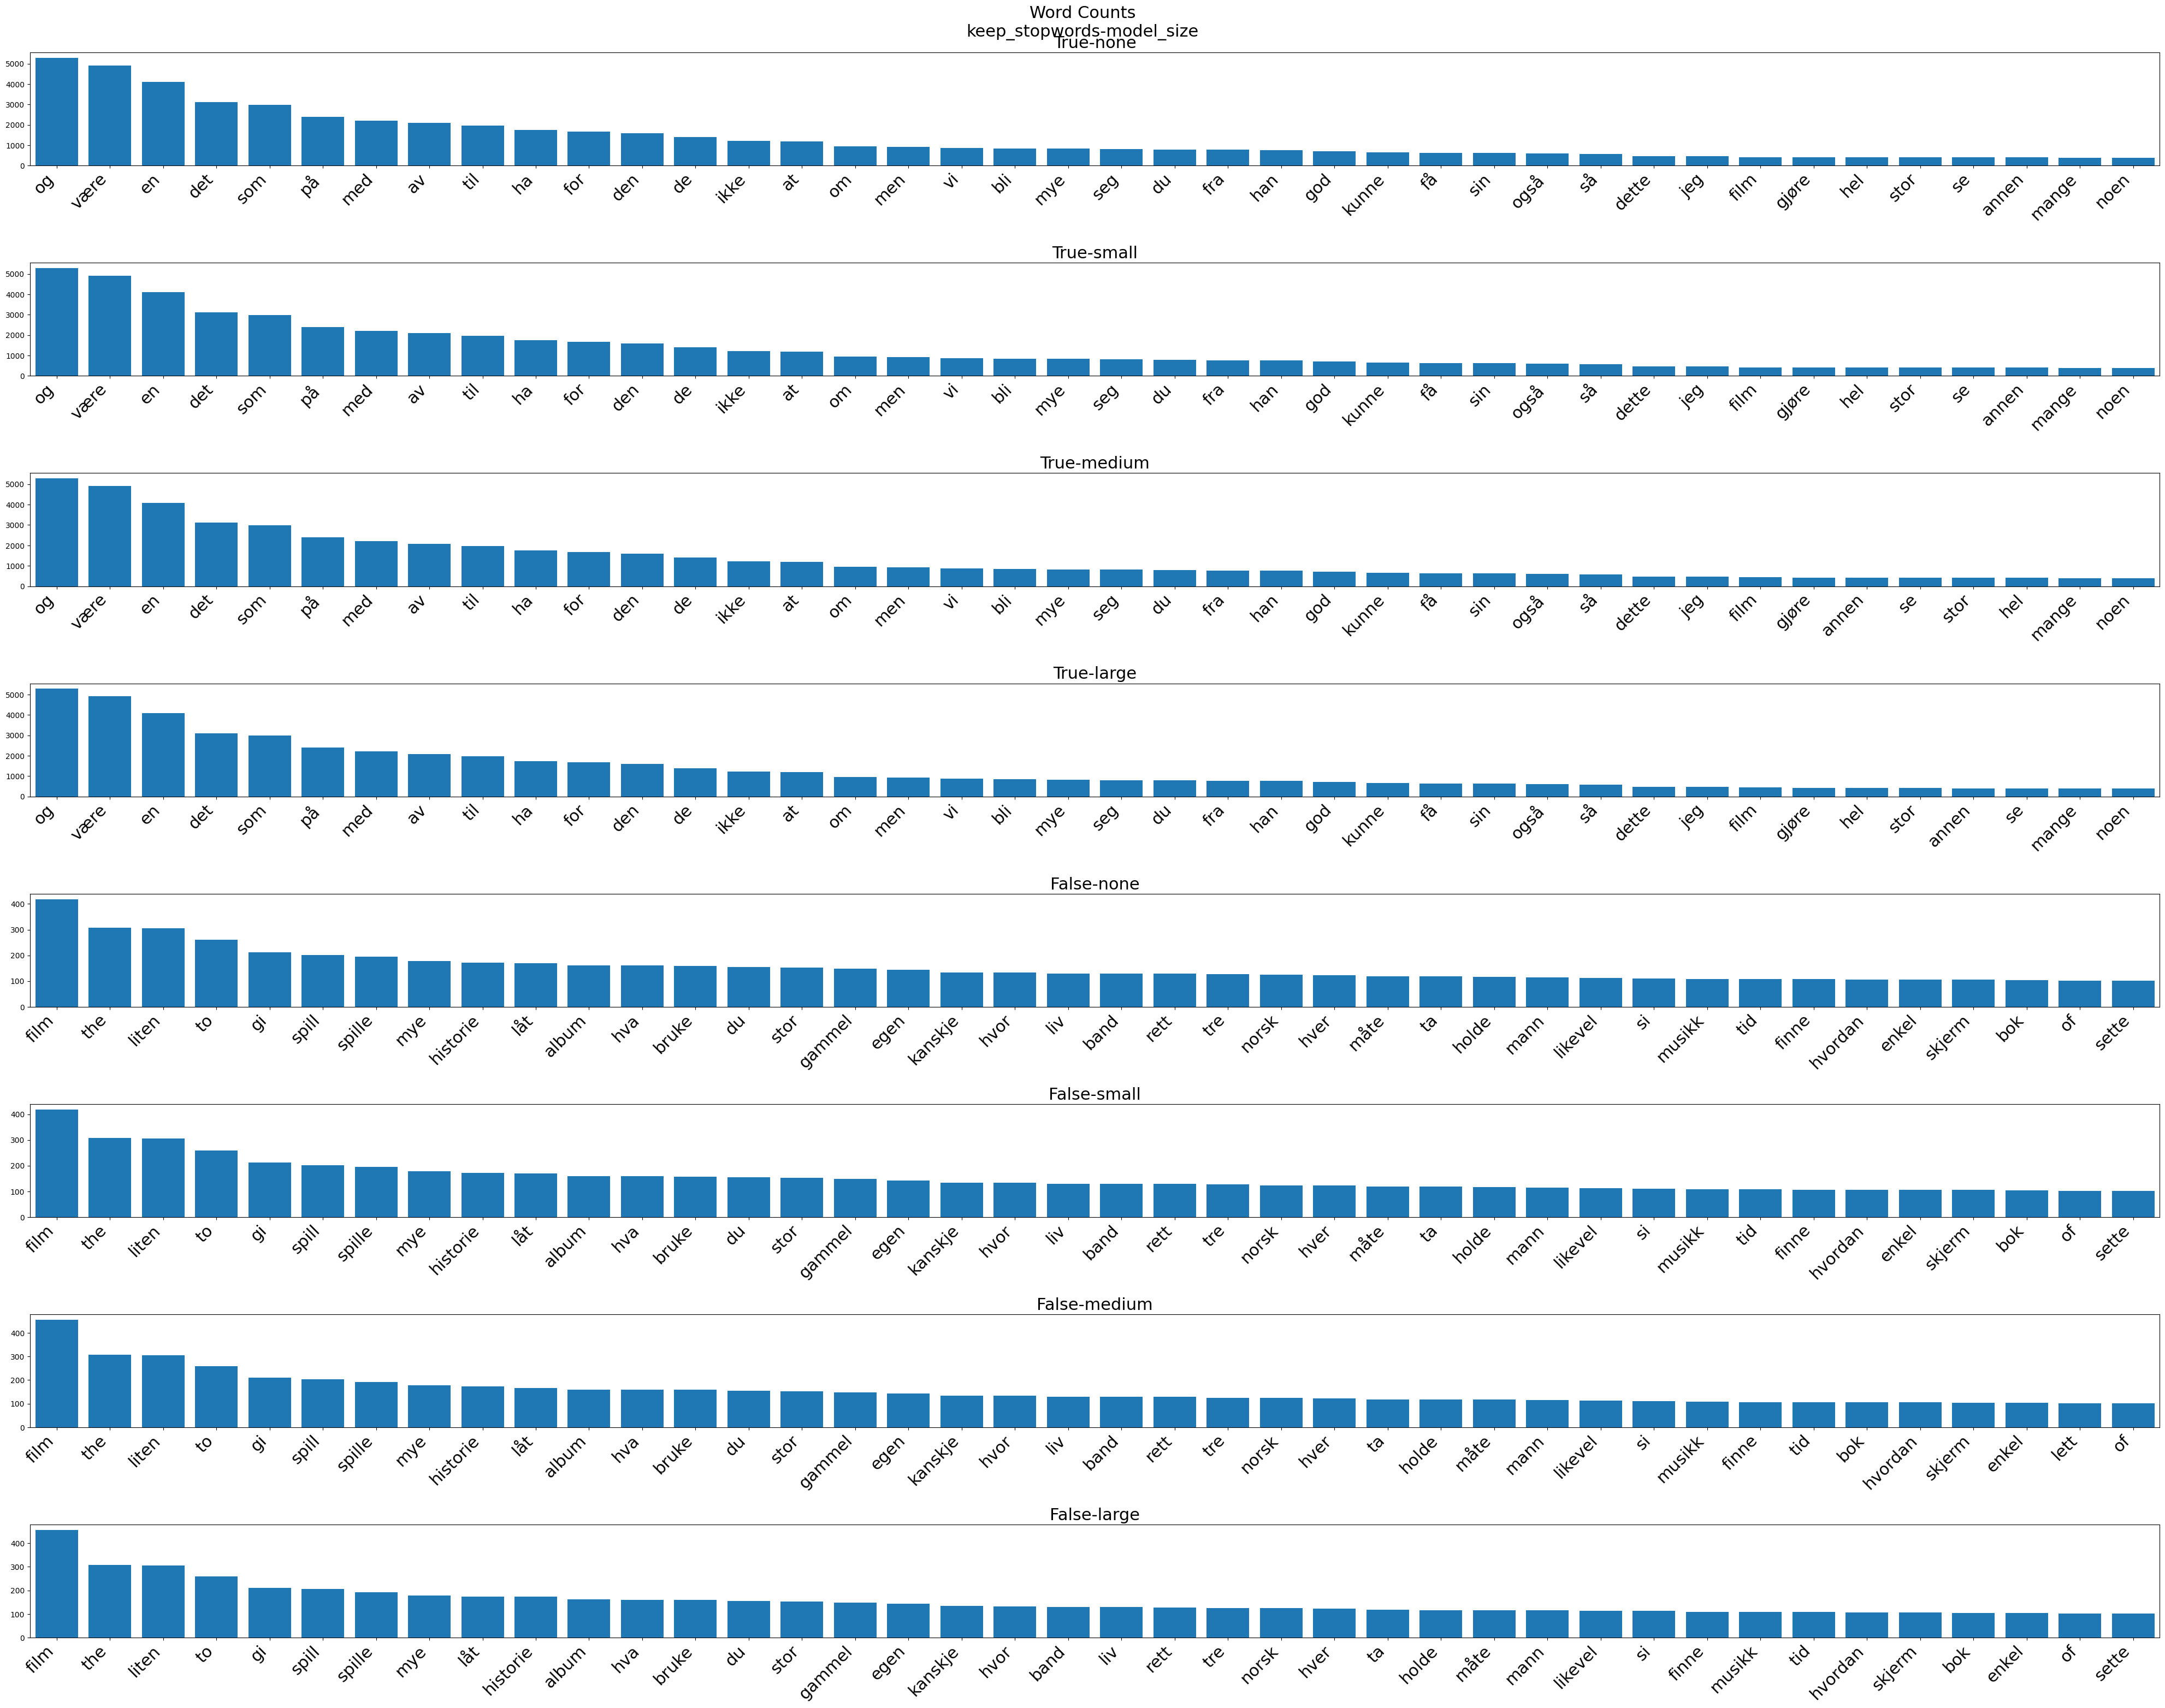

In [22]:
import matplotlib.pyplot as plt

arrays = [x[1] for x in grid.items()]
keys = [x for x in grid.keys()]

# get the unique words that were counted
words = vectorizer.get_feature_names_out()

# create a 2x2 grid of plots
fig, axs = plt.subplots(8, 1, figsize=(40, 32))

# create a bar chart for each list of sentences in each subplot
for i, counts in enumerate(arrays):
    ax = axs[i]  # get the current subplot
    sorted_counts = sorted(zip(words, counts.sum(axis=0)), key=lambda x: -x[1])
    top_words = [w[0] for w in sorted_counts[:40]]
    top_counts = [w[1] for w in sorted_counts[:40]]
    ax.bar(top_words, top_counts)  # create a bar chart in the current subplot
    ax.set_title(keys[i], fontsize=22)  # set the title for the current subplot
    ax.tick_params(axis='x', rotation=45, labelsize=22)  # rotate the x-axis labels for readability
    ax.set_xlim([-0.5, 39.5])  # adjust the x-axis limit to include all the bars
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')  # align the labels to the right
        tick.set_x(-0.25)  # shift the labels to the left by 0.25 units


# remove the unused subplot
if len(arrays) < 4:
    axs[-1, -1].axis('off')

# add a global title and show the plot
fig.suptitle('Word Counts\nkeep_stopwords-model_size', fontsize=22)
fig.subplots_adjust(top=0.9)
fig.tight_layout(pad=2.0)
plt.show()

In the Graphs over we se that Lemmatization increases the number of most common words without introducing that many new words, and we see that there are a lot of stopwords that are removed. "True-none" is our combined text withouth anny stopword removal nor lemmatization.

Through testing with gridsearch and multiple parameters we found that Support Vector-Machines Classifier outperformed other estimators on our dataset. 

To find the optimal parameters for SVC we used a pipeline and grid-search to look for hyperparameters. Since we built a custom lemmatizer, we had to run multiple successive grid searches with different lemmatization options. Although we tried to create a pipeline-compatible solution, we ran into problems, so in the interest of time we moved on. If we had more time, we would have used this guide: [Guide](https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156?gi=8d6de1529edc)

We tested two different bag-of-words models: a CountVectorizer and a TfidfVectorizer. Interestingly, in sklearn, a TfidfVectorizer with the argument `use_idf=False` is identical to a CountVectorizer. Therefore, our grid search only had to include a TfidfVectorizer, and we were able to test both approaches simply by modifying `use_idf`.

Our lemmatizer removes at most about 20% of the complexity. This seems like a small amount, as words usually have multiple forms. However, we have found that there are a lot of non-Norwegian words in our data, for example model numbers, brand names  etc. These words may be still important for the sentiment analysis, and we will test this hypothesis in training.

In [23]:
# Since scikitlearn's GridSearchCV automatically splits data in the
# cross validation prosess, we combine it here
text_comb = text['train'] + text['test'] + text['dev']
labels_comb = labels['train'] + labels['test'] + labels['dev']

The function for multiple successive grid seaches

In [24]:
def prim_grid(pipe, params, text, labels):

    result = {}
    i = 0
    times = []

    # we itterate trough language models and lists of stopwords so that we can make a dictionary of results.
    # and we print the progress of oure search
    for model in nb_nlp:
        for stop_bool in [True, False]:
            # records the current time since inception in seconds
            start = time()

            text = lemmatizer(text, nb_nlp[model], stop=stop_bool)
            grid = GridSearchCV(pipe, params, n_jobs=-1)
            grid.fit(text, labels)

            score = grid.best_score_

            result[score] = grid.best_params_
            result[score]['lemm__models'] = model
            result[score]['lemm__stop'] = stop_bool

            stop = time()

            # adds the running time to times list
            times.append(stop-start)

            i += 1

            #find the average time
            time_left_s = ((len(nb_nlp)*2)-i)*(sum(times)/len(times))
            
            # translate time to hours minutes and seconds
            if time_left_s < 60.0:
                time_left = f'{round(time_left_s)} seconds'
            else:
                if time_left_s < 3600.0:
                    time_left_m = round(time_left_s/60)
                    time_left_s = round(time_left_s%60)
                    time_left = f'{time_left_m} minutes and {time_left_s} seconds'
                else:
                    time_left_h = round(time_left_s/3600)
                    time_left_m = round((time_left_s%3600)/60)
                    time_left_s = round((time_left_s%3600)%60)
                    time_left = f'{time_left_h} hours, {time_left_m} minutes and {time_left_s} seconds'

            clear_output(wait=True)
            print('progress')
            print(f'{(i/(len(nb_nlp)*2))*100}% \nestimated time left: {time_left}')

    return result

In [25]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

result = prim_grid(pipe, params, text_comb, labels_comb)

TypeError: lemmatizer() got an unexpected keyword argument 'stop'

Below are the optimal parameters from a 10 houre parameter search.

In [ ]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.6434453383814482 
parameters:{'clf__C': 1000, 'clf__gamma': 1, 'vect__min_df': 2, 'vect__ngram_range': (1, 1), 'vect__use_idf': True, 'lemm__models': 'medium', 'lemm__stop': True}


Next, we plot a confusion matrix of our best-performing model.

average accuracy; 0.6435152374202693
f1 weighted score: 0.6283201453029899
AxesSubplot(0.125,0.11;0.62x0.77)


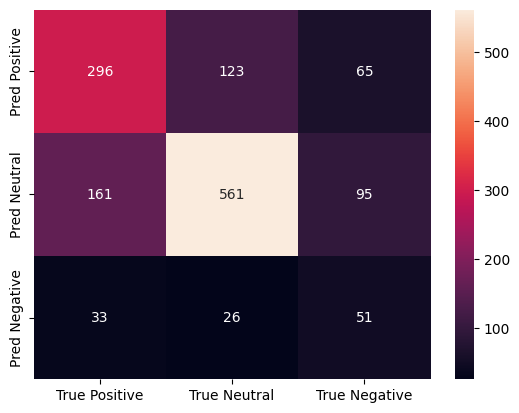

In [ ]:
from seaborn import heatmap
from sklearn.metrics import f1_score
pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=2, use_idf=True)),
                 ('clf', SVC(C=1000, gamma=1))])

x_train = text['train']+text['test']
x_train = lemmatizer(x_train, nb_nlp['medium'], True)
x_test = text['dev']
x_test = lemmatizer(x_test, nb_nlp['medium'], True)
y_train = labels['train']+labels['test']
y_test = labels['dev']

pipe.fit(x_train, y_train)

prediction = pipe.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print('average accuracy;', pipe.score(x_test, y_test))
print('f1 weighted score:', f1_score(y_test, prediction, average='weighted'))
print(heatmap(matrix, annot=True, fmt='d'))

The resulting accuracy is at 64%. This seems low, and we could probably get a higher score with more training data. As we see in the confusion matrix, our main problem is the lack of negative labels. There are so few sentences with a negative label that the model struggles at predicting them accurately.

Researchers have found that humans agree on the sentiment of a sentence about 80-85% of the time (https://mashable.com/archive/sentiment-analysis). This means that if our model were to get an accuracy of 100%, then it would still only be about 80% accurate from a human perspective. This also means that the data is inconsistently labelled since about 20% of the labels are disputable, so we should accept accuracies of around 80% as being "as good as it gets".

source:
Sentiment Analysis: High-impact Strategies - What You Need to Know: Definitions, Adoptions, Impact, Benefits, Maturity, Vendors

Back to our model: When looking at the confusion matrix, our model seems to be biased toward neutral data. To address this, we'll perform a gridsearch with balanced data and train a new model.

In [ ]:
print(f'Number of positive sentiments:{len([x for x in labels_comb if x=="Positive"])}')
print(f'Number of neutral sentiments:{len([x for x in labels_comb if x=="Neutral"])}')
print(f'Number of negative sentiments:{len([x for x in labels_comb if x=="Negative"])}')

In [ ]:
def balance(text:list, labels:list, bal_len:int):
    result_text = []
    result_labels = []

    n_positive = 0
    n_neutral = 0
    n_negative = 0

    # balance by looking for lables, 
    # adding corresponding text and labels to a list 
    # and count different types of labels

    for index in range(0, len(labels_comb)):
        label = labels_comb[index]
        match label:
            case 'Positive':
                if n_positive < bal_len:
                    result_text.append(text_comb[index])
                    result_labels.append(labels_comb[index])
                    n_positive += 1
            
            case 'Neutral':
                if n_neutral < bal_len:
                    result_text.append(text_comb[index])
                    result_labels.append(labels_comb[index])
                    n_neutral += 1
            
            case 'Negative':
                if n_negative < bal_len:
                    result_text.append(text_comb[index])
                    result_labels.append(labels_comb[index])
                    n_negative += 1

In [ ]:
bal_text_comb = []
bal_label_comb = []
n_positive = 0
n_neutral = 0
n_negative = 0

# balance by looking for lables, 
# adding corresponding text and labels to a list 
# and count different types of labels

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1663:
                bal_text_comb.append(text_comb[index])
                bal_label_comb.append(labels_comb[index])
                n_negative += 1

In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer()),
                 ('clf', SVC())])

params = {'clf__C': [0.001, 1, 1000],
          'clf__gamma': [0.1, 1, 10],
          'vect__ngram_range': [(1,1), (1,2), (1,3)],
          'vect__use_idf': [True, False],
          'vect__min_df': [0, 1, 2, 3]}

result = prim_grid(pipe, params, bal_text_comb, bal_label_comb)

progress
66.66666666666666% 
estimated time left: 48.02491105000178 minuts and 1.4946630001068115 seconds


In [ ]:
max_score = max(result.keys())
print(f'score:{max_score} \nparameters:{result[max_score]}')

score:0.5488079468867525 
parameters:{'clf__C': 1, 'clf__gamma': 1, 'vect__min_df': 3, 'vect__ngram_range': (1, 1), 'vect__use_idf': False, 'lemm__models': 'medium', 'lemm__stop': True}


training with new parameters optimized for balanced data

average accuracy; 0.5414599574769667
f1 weighted score: 0.5567911011964015
AxesSubplot(0.125,0.11;0.62x0.77)


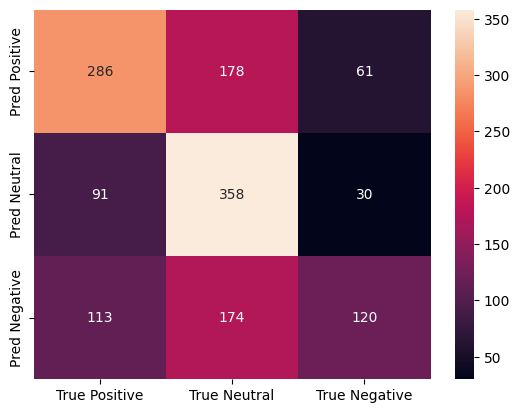

In [ ]:
pipe2 = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=3, use_idf=False)),
                 ('clf', SVC(C=1, gamma=1))])

bal_x_train = []
bal_y_train = []
x_train = text['train']+text['test']
x_train = lemmatizer(x_train, nb_nlp['medium'], True)
y_train = labels['train']+labels['test']

n_positive = 0
n_neutral = 0
n_negative = 0

for index in range(0, len(labels_comb)):
    label = labels_comb[index]
    match label:
        case 'Positive':
            if n_positive < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_positive += 1
        
        case 'Neutral':
            if n_neutral < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_neutral += 1
        
        case 'Negative':
            if n_negative < 1452:
                bal_x_train.append(x_train[index])
                bal_y_train.append(y_train[index])
                n_negative += 1


x_test = text['dev']
x_test = lemmatizer(x_test, nb_nlp['medium'], True)
y_test = labels['dev']

pipe2.fit(bal_x_train, bal_y_train)

prediction = pipe2.predict(x_test)

cnf_mtrx = confusion_matrix(prediction, y_test, labels = ['Positive', 'Neutral', 'Negative'])

matrix = pandas.DataFrame(cnf_mtrx, index = ['Pred Positive', 'Pred Neutral', 'Pred Negative'], columns = ['True Positive', 'True Neutral', 'True Negative'])

print('average accuracy;', pipe2.score(x_test, y_test))
print('f1 weighted score:', f1_score(y_test, prediction, average='weighted'))
print(heatmap(matrix, annot=True, fmt='d'))

We now get an accuracy of 54% and an F1 of 56%. While this is lower than before (64% & 63%), we are now better at predicting negative values. Although our F1 score is higher than our accuracy when using balanced data, it is still lower overall compared to using unbalanced data.

Now, we'll create a model that can be used in real-time to test on custom sentences! You'll be able to play with it below.

In [ ]:
pipe = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,1), min_df=2, use_idf=True)),
                 ('clf', SVC(C=1000, gamma=1))])

pipe.fit(text_comb, labels_comb)

Pipeline(steps=[('vect', TfidfVectorizer(min_df=2)),
                ('clf', SVC(C=1000, gamma=1))])

In [ ]:
def pred_n_return(pipe:Pipeline, nlp:spacy, stop:bool, sentences:list=[]):
    """tries to predict the sentiment of a list of senteces if a list of sentences is given, 
    else it prompts for sentence until told to stop

    Args:
        pipe (Pipeline): a sklearn pipeline
        nlp (spacy): a language model
        stop (bool): if stopword removal should be implemented or not
        sentences (list): list of sentences that is empty by defaul
    """
    sent = ''
    if sentences==[]:
        while sent != ['stop']:
            sent = [input("Type 'stop' to stop \nType a sentence in norwegian:")]
            sent = lemmatizer(sent, nlp, stop)
            result = pipe.predict(sent)
            print(f"the sentence is {result[0]}")
    else:
        sent = lemmatizer(sentences, nlp, stop)
        result = pipe.predict(sent)
        for i in range(0, len(result)):
            print(sentences[i], 'is:', result[i])

Here is the function that you can use to test the prediction power of our model on Norwegian sentences. Try it out!

In [ ]:
# if empty wil prompt continusly for sentences
list_of_sent = []
pred_n_return(pipe, nb_nlp['medium'], True, list_of_sent)

NameError: name 'pred_n_return' is not defined

stopwords sourced from:  
https://searchcode.com/file/257516021/data/stopwords/stopwords-nb.txt/  
https://raw.githubusercontent.com/stopwords-iso/stopwords-no/master/stopwords-no.json

Dataset cloned from github: https://github.com/ltgoslo/norec_sentence

Kutuzov, A., Barnes, J., Velldal, E., Øvrelid, L., & Oepen, S. (2021). Large-Scale Contextualised Language Modelling for Norwegian. Proceedings of the 23rd Nordic Conference on Computational Linguistics (NoDaLiDa 2021).

Øvrelid, L., Mæhlum, P., Barnes, J., & Velldal, E. (2020). A Fine-grained Sentiment Dataset for Norwegian. Proceedings of the 12th Edition of the Language Resources and Evaluation Conference. Marseille, France, 2020.